World bounds (excluding Antarctica): [-179.99998854  -58.49860904  179.99998854   83.62360016]
Processing Field Capacity (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.04 - 0.66
Processing Wilting Point (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.01 - 0.46
Processing Available Water Capacity (mm/mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 0.40
Processing Effective Plant Rooting Depth (m) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 126.11
Processing Water Holding Capacity (mm) with natural_breaks classification...


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


  Original range: 0.00 - 21079.29


c:\Users\jvalenciag\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


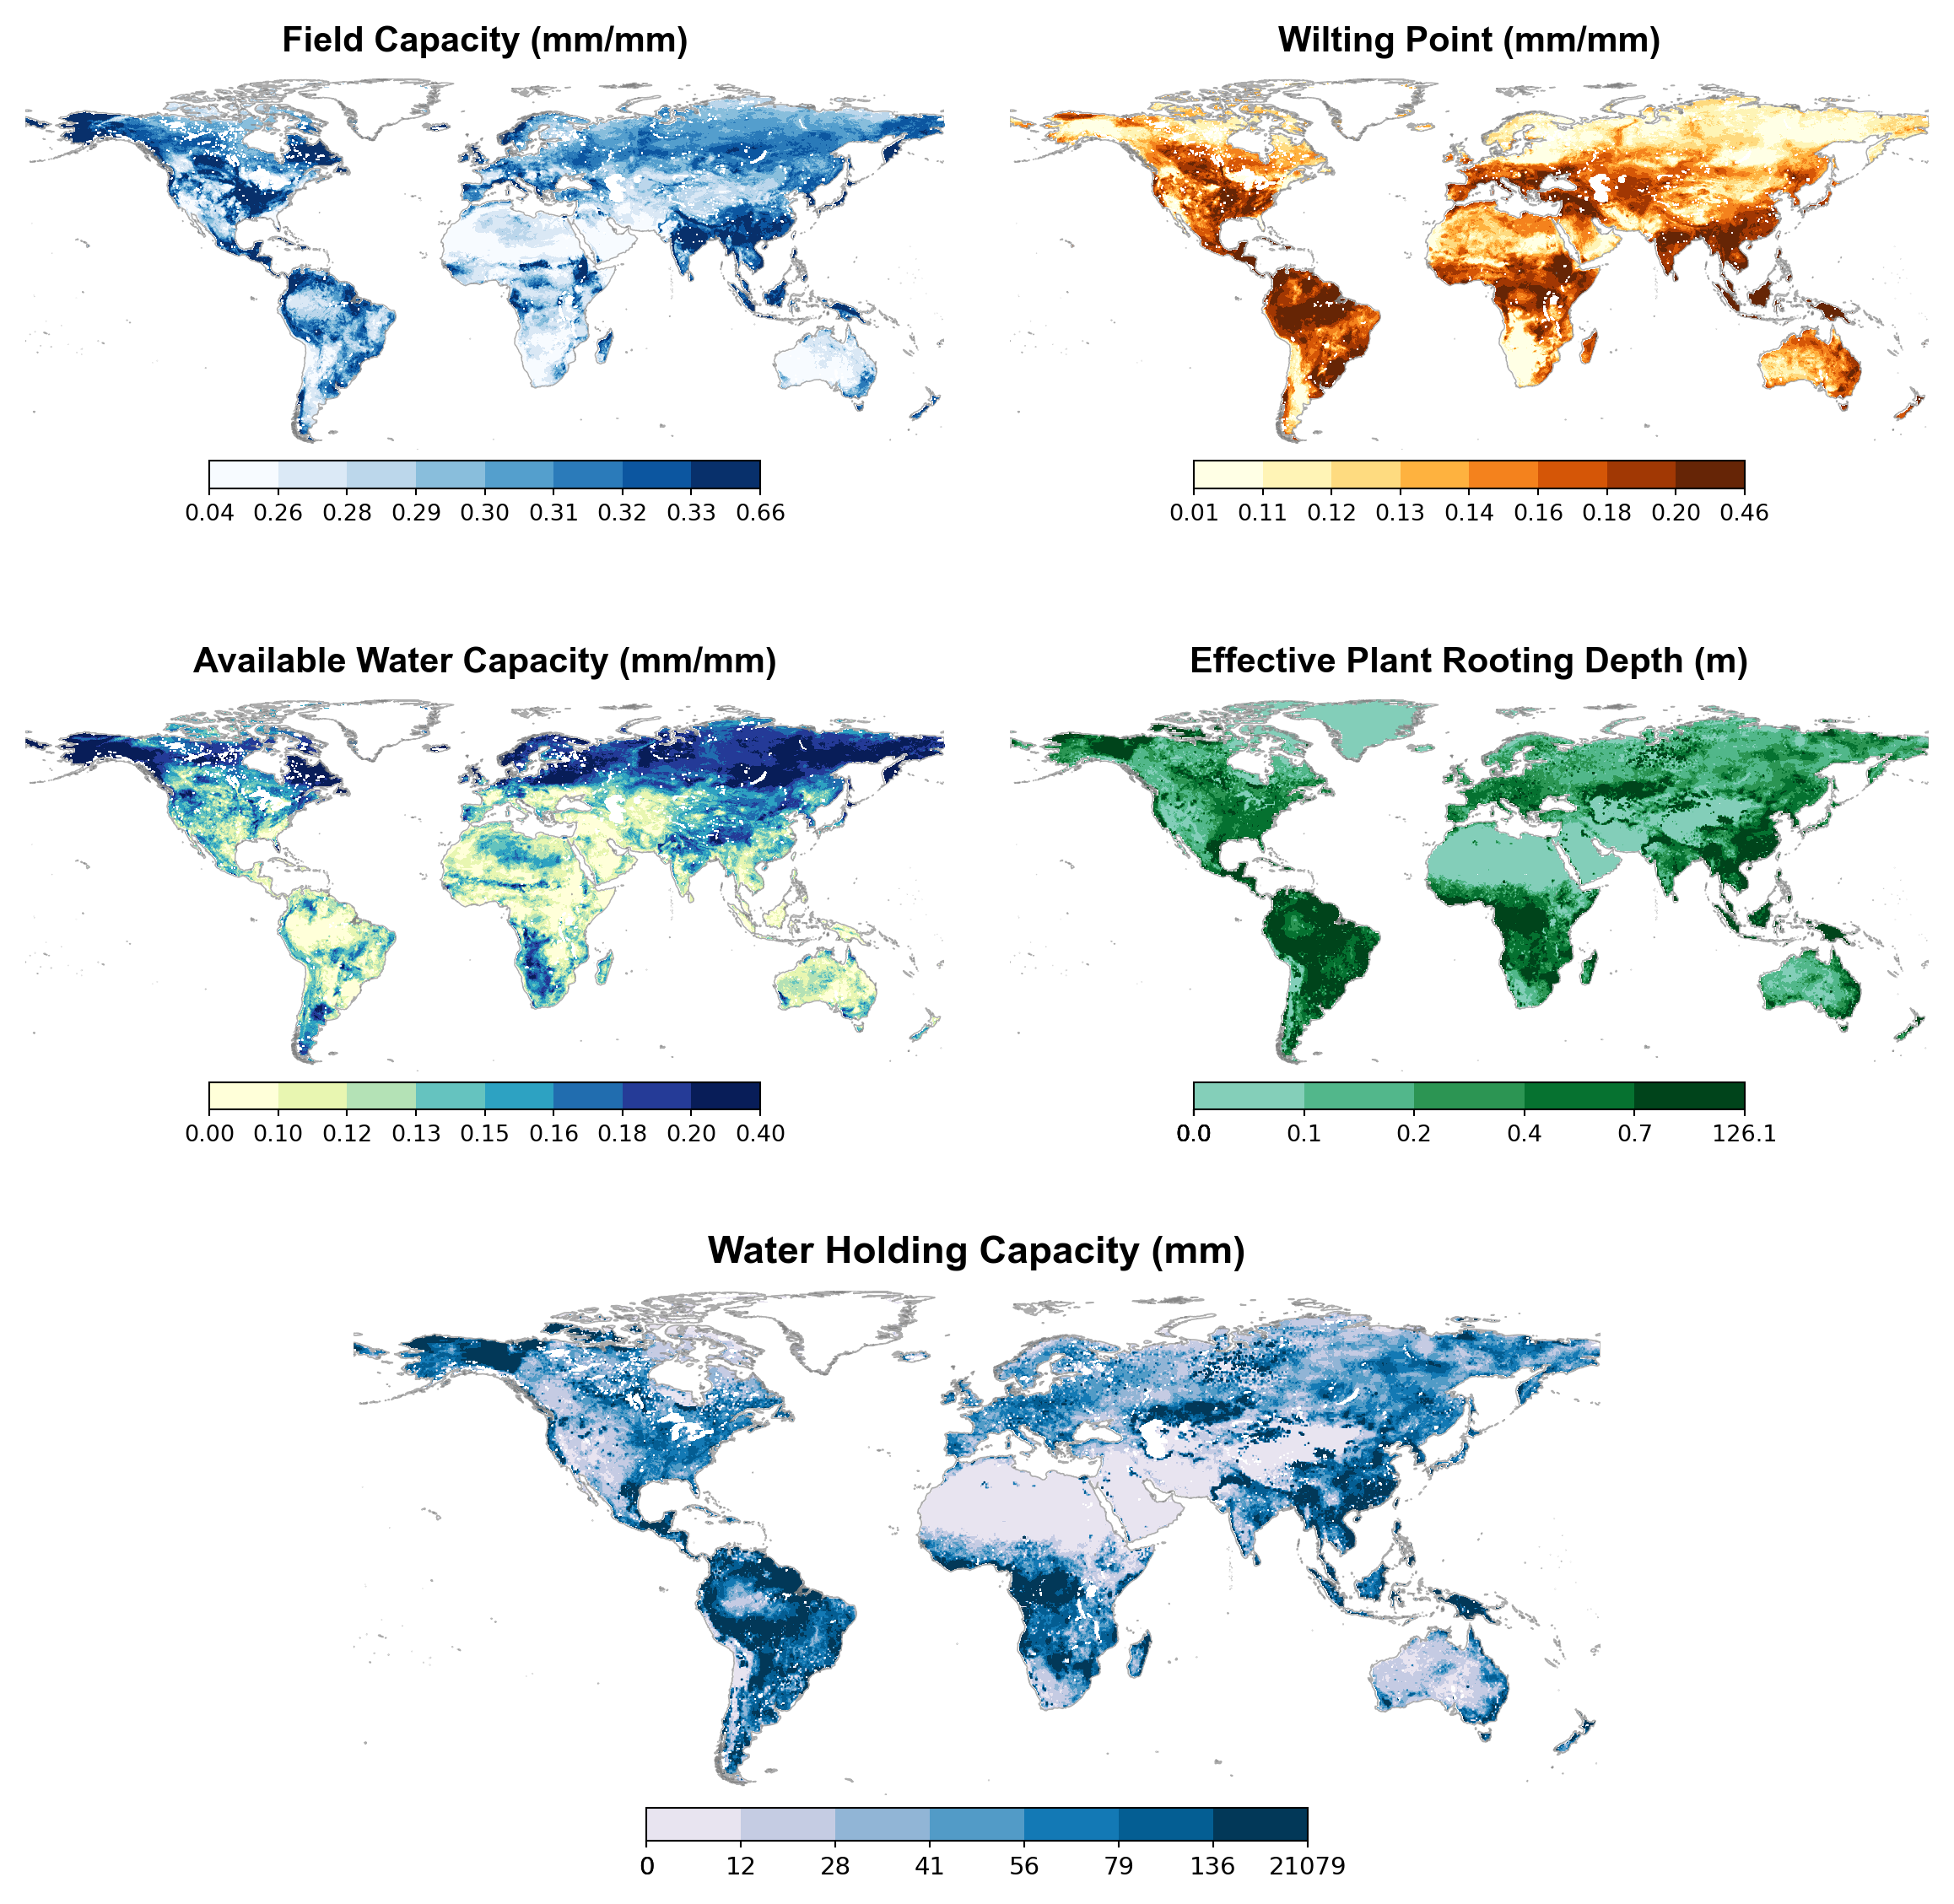

In [2]:
import rasterio
from rasterio.enums import Resampling
from affine import Affine
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import BoundaryNorm
import numpy as np

# ==============================================
# ⚙️ RASTER HANDLING UTILITIES
# ==============================================

def load_and_resample_raster(path, max_pixels=4096 * 4096):
    """Load and optionally resample raster to avoid memory issues while preserving data range."""
    with rasterio.open(path) as src:
        width, height = src.width, src.height
        total_pixels = width * height
        scale = 1.0
        if total_pixels > max_pixels:
            scale = (max_pixels / float(total_pixels)) ** 0.5
        out_width, out_height = max(1, int(width * scale)), max(1, int(height * scale))
        
        # Use bilinear resampling to better preserve data characteristics
        data = src.read(
            1,
            out_shape=(out_height, out_width),
            resampling=Resampling.bilinear
        )
        new_transform = src.transform * Affine.scale(width / out_width, height / out_height)
        nodata = src.nodata
        
        # Get original data statistics for reference
        original_min = src.statistics(1).min
        original_max = src.statistics(1).max
        
    return data, new_transform, nodata, original_min, original_max


def get_valid_data(data, nodata):
    """Return valid (non-nodata) values."""
    mask = data != nodata if nodata is not None else ~np.isnan(data)
    return data[mask]


def auto_bins_quantile(data, nodata, num_bins=7, original_min=None, original_max=None):
    """Create automatic bin intervals based on quantiles (equal count)."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available, otherwise compute from resampled data
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Use quantiles from the resampled data for bin distribution
    quantiles = np.linspace(0, 100, num_bins)
    bins = np.percentile(valid, quantiles)
    
    # Ensure bins span the full original range
    bins[0] = vmin
    bins[-1] = vmax
    
    # Ensure unique bins
    bins = np.unique(bins)
    
    # If we have fewer unique bins than requested, fill with linspace
    if len(bins) < num_bins:
        if vmin == vmax:
            vmax = vmin + 1
        bins = np.linspace(vmin, vmax, num_bins)
    
    return bins


def auto_bins_logarithmic(data, nodata, num_bins=7, original_min=None, original_max=None):
    """Create logarithmic bins for data with heavy skew toward low values."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Handle zero or negative values by adding offset
    offset = 0
    if vmin <= 0:
        offset = abs(vmin) + 1
        vmin += offset
        vmax += offset
    
    # Create logarithmic bins
    log_min = np.log10(vmin)
    log_max = np.log10(vmax)
    log_bins = np.linspace(log_min, log_max, num_bins)
    bins = 10 ** log_bins
    
    # Remove offset if it was added
    if offset > 0:
        bins -= offset
    
    return bins


def auto_bins_natural_breaks(data, nodata, num_bins=9, original_min=None, original_max=None):
    """Create bins using natural breaks (Jenks) approach - simplified version."""
    valid = get_valid_data(data, nodata)
    if len(valid) == 0:
        return np.linspace(0, 1, num_bins)
    
    # Use original min/max if available
    vmin = original_min if original_min is not None else np.nanmin(valid)
    vmax = original_max if original_max is not None else np.nanmax(valid)
    
    # Sample data if too large for efficient processing
    if len(valid) > 10000:
        sample_indices = np.random.choice(len(valid), 10000, replace=False)
        valid = valid[sample_indices]
    
    # Sort the data
    sorted_data = np.sort(valid)
    
    # Use histogram to find natural breaks
    hist, edges = np.histogram(sorted_data, bins=num_bins*3)
    
    # Find valleys in the histogram (local minima)
    valleys = []
    for i in range(1, len(hist)-1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            valleys.append(edges[i])
    
    # If we have enough valleys, use them
    if len(valleys) >= num_bins - 1:
        bins = [vmin] + sorted(valleys)[:num_bins-2] + [vmax]
        bins = np.array(bins)
    else:
        # Fall back to quantiles if not enough valleys found
        quantiles = np.linspace(0, 100, num_bins)
        bins = np.percentile(sorted_data, quantiles)
        bins[0] = vmin
        bins[-1] = vmax
    
    return bins


# ==============================================
# 🗺️ PLOTTING UTILITIES
# ==============================================

def plot_raster(ax, data, transform, nodata, var_name, cmap, world, original_min, original_max, 
                bin_method='quantile', world_bounds=None, is_main=False):
    """Plot raster with auto-generated discrete legend bins."""
    if bin_method == 'logarithmic':
        bins = auto_bins_logarithmic(data, nodata, original_min=original_min, original_max=original_max)
    elif bin_method == 'natural_breaks':
        bins = auto_bins_natural_breaks(data, nodata, original_min=original_min, original_max=original_max)
    else:  # default to quantile
        bins = auto_bins_quantile(data, nodata, original_min=original_min, original_max=original_max)
    
    norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, extend="neither")
    
    masked = np.ma.masked_equal(data, nodata) if nodata is not None else data
    
    extent = [
        transform[2],
        transform[2] + transform[0] * data.shape[1],
        transform[5] + transform[4] * data.shape[0],
        transform[5]
    ]
    
    im = ax.imshow(masked, cmap=cmap, norm=norm, extent=extent, 
                   aspect='auto', interpolation='bilinear')
    
    # Line width and alpha for professional appearance
    world.plot(ax=ax, edgecolor='grey', facecolor='none', 
               linewidth=0.4 if is_main else 0.35, alpha=0.65)
    
    # Set axis limits to world bounds (excluding Antarctica)
    if world_bounds is not None:
        minx, miny, maxx, maxy = world_bounds
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
    
    # Professional title formatting for publication
    title_size = 11 if is_main else 10
    ax.set_title(var_name, fontsize=title_size, fontweight='bold', pad=8, 
                 fontname='Arial')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    return im, norm, bins


def add_colorbar(fig, ax, im, bins, is_main=False):
    """Attach discrete colorbar with smart decimal formatting."""
    # Smaller, more proportional colorbar
    cbar = fig.colorbar(
        im, ax=ax, orientation='horizontal',
        pad=0.02, fraction=0.05, shrink=1.0,
        ticks=bins, extend='neither'
    )
    
    # Smart formatting: 2 decimals only if max value < 1, otherwise integer/1 decimal
    data_range = bins[-1] - bins[0]
    max_val = bins[-1]
    
    if max_val < 1:
        # Values less than 1: use 2 decimals
        labels = [f'{tick:.2f}' for tick in bins]
    elif max_val < 150:
        # Values between 1-10: use 1 decimal
        labels = [f'{tick:.1f}' for tick in bins]
    else:
        # Values >= 10: use integers
        labels = [f'{int(round(tick))}' for tick in bins]
    
    cbar.set_ticklabels(labels)
    
    # Compact label sizing
    label_size = 7 if is_main else 6.5
    cbar.ax.tick_params(labelsize=label_size, length=2, width=0.5, pad=2)
    
    # Remove colorbar outline for cleaner look
    cbar.outline.set_linewidth(0.5)
    
    return cbar


# ==============================================
# 🚀 MAIN EXECUTION
# ==============================================

def main():
    # Load world boundaries
    #world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Countries_Generalized_WGS84.shp")
    world = gpd.read_file("Z:/PhD_Datasets&Analysis/Info_Inputs/Reference_Layers/World_Generalized_WGS84.shp")
    
    # Filter out Antarctica
    for col in ['CONTINENT', 'continent', 'Continent', 'COUNTRY', 'Country', 'NAME', 'name']:
        if col in world.columns:
            world = world[world[col] != 'Antarctica']
            break
    
    # Get the bounds of the world (excluding Antarctica)
    world_bounds = world.total_bounds  # returns (minx, miny, maxx, maxy)
    print(f"World bounds (excluding Antarctica): {world_bounds}")
    
    # File paths and titles
    geotiff_paths = [
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/Vol_Water_Content/33kPa/FC33_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/Vol_Water_Content/1500kPa/WP_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/SoilGrids/AWC_Standard_Method/Only_Positive_Values/AWC_FC33_WGS84.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/Global_effective_plant_rooting_depth/data/Effective_Rooting_Depth_With_Zeros_Clipped.tif',
        'Z:/PhD_Datasets&Analysis/Info_Inputs/Water_Holding_Capacity/WHC_FC33_WGS84.tif'
    ]
    
    names = [
        'Field Capacity (mm/mm)',
        'Wilting Point (mm/mm)',
        'Available Water Capacity (mm/mm)',
        'Effective Plant Rooting Depth (m)',
        'Water Holding Capacity (mm)'
    ]
    
    colormaps = ['Blues', 'YlOrBr', 'YlGnBu', 'BuGn', 'PuBu']
    
    # Define classification methods for each variable
    bin_methods = ['natural_breaks', 'natural_breaks', 'natural_breaks', 'natural_breaks', 'natural_breaks']
    
    # Larger figure dimensions for better map-to-colorbar ratio
    fig = plt.figure(figsize=(8, 8), dpi=300)  # Increased width from 7.2 to 9
    
    # Create grid with reduced vertical spacing
    gs = GridSpec(3, 6, figure=fig, 
                  hspace=0.12, wspace=0.25,  # Reduced wspace for more map space
                  height_ratios=[1.5, 1.5, 1.8],
                  left=0.04, right=0.98, top=0.97, bottom=0.03)  # Maximized plotting area
    
    axes = [
        fig.add_subplot(gs[0, 0:3]),  # Row 1, left
        fig.add_subplot(gs[0, 3:6]),  # Row 1, right
        fig.add_subplot(gs[1, 0:3]),  # Row 2, left
        fig.add_subplot(gs[1, 3:6]),  # Row 2, right
        fig.add_subplot(gs[2, 1:5])   # Row 3, centered
    ]
    
    # Plot all rasters
    for idx, (ax, path, var_name, cmap, bin_method) in enumerate(zip(axes, geotiff_paths, names, colormaps, bin_methods)):
        is_main = (idx == 4)  # Last map is the main one
        print(f"Processing {var_name} with {bin_method} classification...")
        data, transform, nodata, original_min, original_max = load_and_resample_raster(path)
        im, norm, bins = plot_raster(ax, data, transform, nodata, var_name, cmap, world, 
                                     original_min, original_max, bin_method=bin_method,
                                     world_bounds=world_bounds, is_main=is_main)
        add_colorbar(fig, ax, im, bins, is_main=is_main)
        print(f"  Original range: {original_min:.2f} - {original_max:.2f}")
    
    # Optional: Save the figure for publication
    # plt.savefig('soil_water_capacity_maps.png', dpi=300, bbox_inches='tight', 
    #             facecolor='white', edgecolor='none')
    # plt.savefig('soil_water_capacity_maps.pdf', dpi=300, bbox_inches='tight')
    
    plt.show()


if __name__ == "__main__":
    main()